# Dedupe Model - Entity Resolution con Machine Learning

## Obiettivo 4.F
Addestrare un modello usando la libreria **Python Dedupe** e valutare le pipeline:
- **B1-Dedupe**: Blocking (Manufacturer+Model) + Dedupe ML
- **B2-Dedupe**: Blocking (Manufacturer+Model+Year) + Dedupe ML

### Metriche di Valutazione:
- **Precision**: % di match predetti che sono veri match
- **Recall**: % di veri match correttamente identificati
- **F1-Score**: Media armonica di Precision e Recall
- **Tempi di Training**: Tempo per addestrare il modello
- **Tempi di Inferenza**: Tempo per classificare le coppie candidate

### Differenza rispetto a Record Linkage:
- **Record Linkage**: Regole threshold-based (deterministiche)
- **Dedupe**: Machine Learning supervisionato (probabilistico)

### Nota:
La libreria Dedupe usa Active Learning per l'etichettatura, ma noi useremo il ground-truth già disponibile per il training supervisionato.

## 1. Import Librerie e Setup

In [1]:
# Installazione dedupe (se non presente)
# !pip install dedupe

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import os
from datetime import datetime
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configurazione visualizzazioni
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

print("✅ Librerie importate con successo!")

✅ Librerie importate con successo!


## 2. Caricamento Dataset e Ground-Truth

In [21]:
print("CARICAMENTO DATASET")
print("="*100)

# Carica dataset NO-VIN
print("\n📁 Dataset NO-VIN:")
df_A = pd.read_csv('ground_truth/dataset_A_no_vin.csv')
df_B = pd.read_csv('ground_truth/dataset_B_no_vin.csv')

print(f"  Dataset A (Craigslist): {len(df_A):,} righe × {len(df_A.columns)} colonne")
print(f"  Dataset B (Used Cars): {len(df_B):,} righe × {len(df_B.columns)} colonne")

# Carica ground-truth
print("\n📁 Ground-Truth:")
df_ground_truth = pd.read_csv('ground_truth/ground_truth_complete.csv')
df_gt_positive = df_ground_truth[df_ground_truth['label'] == 1].copy()

print(f"  Ground-Truth Completo: {len(df_ground_truth):,} coppie")
print(f"  Ground-Truth Positivi: {len(df_gt_positive):,} veri match")

# Carica train/validation/test split
print("\n📁 Train/Validation/Test Split:")
df_train = pd.read_csv('ground_truth/train.csv')
df_val = pd.read_csv('ground_truth/validation.csv')
df_test = pd.read_csv('ground_truth/test.csv')

print(f"  Train: {len(df_train):,} coppie")
print(f"  Validation: {len(df_val):,} coppie")
print(f"  Test: {len(df_test):,} coppie")

# Carica coppie candidate da blocking
print("\n📁 Coppie Candidate (da Blocking):")
df_candidates_B1 = pd.read_csv('blocking_results/candidates_B1.csv')
df_candidates_B2 = pd.read_csv('blocking_results/candidates_B2.csv')

print(f"  B1 (Manufacturer+Model): {len(df_candidates_B1):,} coppie")
print(f"  B2 (Manufacturer+Model+Year): {len(df_candidates_B2):,} coppie")

CARICAMENTO DATASET

📁 Dataset NO-VIN:
  Dataset A (Craigslist): 14,492 righe × 19 colonne
  Dataset B (Used Cars): 15,375 righe × 19 colonne

📁 Ground-Truth:
  Ground-Truth Completo: 15,412 coppie
  Ground-Truth Positivi: 3,853 veri match

📁 Train/Validation/Test Split:
  Train: 10,788 coppie
  Validation: 2,311 coppie
  Test: 2,313 coppie

📁 Coppie Candidate (da Blocking):
  B1 (Manufacturer+Model): 964,002 coppie
  B2 (Manufacturer+Model+Year): 77,087 coppie


## 3. Feature Engineering per ML

Calcoliamo le stesse features di similarità usate in Record Linkage, ma le useremo come input per un modello ML.

In [3]:
# Importa jellyfish per string similarity
try:
    import jellyfish
    print("✅ jellyfish importato")
except ImportError:
    print("⚠️ Installazione jellyfish...")
    !pip install jellyfish
    import jellyfish
    print("✅ jellyfish installato e importato")

def compute_features_for_pair(row_a, row_b):
    """
    Calcola features di similarità per una coppia di record.
    
    Returns:
        dict: Features di similarità
    """
    features = {}
    
    # 1. Manufacturer similarity (Jaro-Winkler)
    man_a = str(row_a.get('manufacturer', '')).lower().strip()
    man_b = str(row_b.get('manufacturer', '')).lower().strip()
    if man_a and man_b and man_a != 'nan' and man_b != 'nan':
        features['manufacturer_sim'] = jellyfish.jaro_winkler_similarity(man_a, man_b)
    else:
        features['manufacturer_sim'] = 0.0
    
    # 2. Model similarity (Jaro-Winkler)
    mod_a = str(row_a.get('model', '')).lower().strip()
    mod_b = str(row_b.get('model', '')).lower().strip()
    if mod_a and mod_b and mod_a != 'nan' and mod_b != 'nan':
        features['model_sim'] = jellyfish.jaro_winkler_similarity(mod_a, mod_b)
    else:
        features['model_sim'] = 0.0
    
    # 3. Year match
    year_a = row_a.get('year')
    year_b = row_b.get('year')
    if pd.notna(year_a) and pd.notna(year_b):
        features['year_match'] = 1.0 if int(year_a) == int(year_b) else 0.0
        features['year_diff'] = abs(int(year_a) - int(year_b))
    else:
        features['year_match'] = 0.0
        features['year_diff'] = 99
    
    # 4. Price similarity (Gaussian)
    price_a = row_a.get('price')
    price_b = row_b.get('price')
    if pd.notna(price_a) and pd.notna(price_b) and price_a > 0 and price_b > 0:
        price_diff = abs(price_a - price_b)
        features['price_sim'] = np.exp(-(price_diff - 5000)**2 / (2 * 10000**2))
        features['price_ratio'] = min(price_a, price_b) / max(price_a, price_b)
    else:
        features['price_sim'] = 0.0
        features['price_ratio'] = 0.0
    
    # 5. Mileage similarity (Gaussian)
    mile_a = row_a.get('mileage')
    mile_b = row_b.get('mileage')
    if pd.notna(mile_a) and pd.notna(mile_b) and mile_a > 0 and mile_b > 0:
        mile_diff = abs(mile_a - mile_b)
        features['mileage_sim'] = np.exp(-(mile_diff - 10000)**2 / (2 * 20000**2))
        features['mileage_ratio'] = min(mile_a, mile_b) / max(mile_a, mile_b)
    else:
        features['mileage_sim'] = 0.0
        features['mileage_ratio'] = 0.0
    
    # 6. Fuel match
    fuel_a = str(row_a.get('fuel', '')).lower().strip()
    fuel_b = str(row_b.get('fuel', '')).lower().strip()
    features['fuel_match'] = 1.0 if fuel_a == fuel_b and fuel_a != 'nan' else 0.0
    
    # 7. Transmission match
    trans_a = str(row_a.get('transmission', '')).lower().strip()
    trans_b = str(row_b.get('transmission', '')).lower().strip()
    features['transmission_match'] = 1.0 if trans_a == trans_b and trans_a != 'nan' else 0.0
    
    return features

print("✅ Funzione di feature engineering definita")

✅ jellyfish importato
✅ Funzione di feature engineering definita


In [4]:
def compute_features_for_dataset(df_pairs, df_A, df_B, dataset_name):
    """
    Calcola features per tutte le coppie in un dataset.
    
    Args:
        df_pairs: DataFrame con coppie (craigslist_id/id_A, used_cars_id/id_B, label)
        df_A: Dataset A indicizzato per vehicle_id
        df_B: Dataset B indicizzato per vehicle_id
        dataset_name: Nome per logging
    
    Returns:
        DataFrame con features
    """
    print(f"\nCalcolo features per {dataset_name}...")
    start_time = time.time()
    
    # Determina i nomi delle colonne ID
    if 'craigslist_id' in df_pairs.columns:
        id_a_col = 'craigslist_id'
        id_b_col = 'used_cars_id'
    else:
        id_a_col = 'id_A'
        id_b_col = 'id_B'
    
    # Indicizza i dataset per lookup veloce
    df_A_indexed = df_A.set_index('vehicle_id') if 'vehicle_id' in df_A.columns else df_A
    df_B_indexed = df_B.set_index('vehicle_id') if 'vehicle_id' in df_B.columns else df_B
    
    features_list = []
    
    for idx, row in df_pairs.iterrows():
        id_a = row[id_a_col]
        id_b = row[id_b_col]
        
        try:
            row_a = df_A_indexed.loc[id_a]
            row_b = df_B_indexed.loc[id_b]
            
            features = compute_features_for_pair(row_a, row_b)
            features['id_A'] = id_a
            features['id_B'] = id_b
            if 'label' in row:
                features['label'] = row['label']
            
            features_list.append(features)
        except KeyError:
            # Skip coppie con ID non trovati
            continue
    
    df_features = pd.DataFrame(features_list)
    elapsed = time.time() - start_time
    
    print(f"  ✅ {len(df_features):,} coppie processate in {elapsed:.2f}s")
    
    return df_features, elapsed

print("✅ Funzione di calcolo features per dataset definita")

✅ Funzione di calcolo features per dataset definita


## 4. Preparazione Dati per Training

In [5]:
print("PREPARAZIONE DATI PER TRAINING")
print("="*100)

# Calcola features per train set
df_train_features, time_train_features = compute_features_for_dataset(
    df_train, df_A, df_B, "Train Set"
)

# Calcola features per validation set
df_val_features, time_val_features = compute_features_for_dataset(
    df_val, df_A, df_B, "Validation Set"
)

# Calcola features per test set
df_test_features, time_test_features = compute_features_for_dataset(
    df_test, df_A, df_B, "Test Set"
)

print("\n" + "="*100)
print("RIEPILOGO:")
print(f"  Train: {len(df_train_features):,} coppie con {len(df_train_features.columns)-3} features")
print(f"  Validation: {len(df_val_features):,} coppie")
print(f"  Test: {len(df_test_features):,} coppie")

PREPARAZIONE DATI PER TRAINING

Calcolo features per Train Set...
  ✅ 10,788 coppie processate in 0.75s

Calcolo features per Validation Set...
  ✅ 2,311 coppie processate in 0.15s

Calcolo features per Test Set...
  ✅ 2,313 coppie processate in 0.15s

RIEPILOGO:
  Train: 10,788 coppie con 10 features
  Validation: 2,311 coppie
  Test: 2,313 coppie


In [6]:
# Visualizza features
print("\nEsempio features calcolate (Train):")
print(df_train_features.head())

print("\nStatistiche features:")
feature_cols = [c for c in df_train_features.columns if c not in ['id_A', 'id_B', 'label']]
print(df_train_features[feature_cols].describe())


Esempio features calcolate (Train):
   manufacturer_sim  model_sim  year_match  year_diff  price_sim  price_ratio   mileage_sim  mileage_ratio  \
0          1.000000   0.583333         0.0          1   0.324214     0.499762  9.864879e-01       0.000301   
1          0.000000   0.430556         0.0          5   0.899977     0.714469  1.766980e-20       0.000015   
2          0.633333   0.601190         1.0          0   0.000000     0.000000  9.749503e-01       0.002179   
3          0.000000   0.430556         0.0          6   0.045148     0.400862  1.568400e-03       0.000037   
4          1.000000   1.000000         1.0          0   0.969233     0.916664  8.824969e-01       1.000000   

   fuel_match  transmission_match        id_A       id_B  label  
0         1.0                 0.0  7316716231  267497466      0  
1         1.0                 1.0  7307279962  272550118      0  
2         1.0                 1.0  7315558814  270129081      0  
3         1.0                 1.0  731

In [7]:
# Prepara X e y per training
feature_columns = ['manufacturer_sim', 'model_sim', 'year_match', 'year_diff',
                   'price_sim', 'price_ratio', 'mileage_sim', 'mileage_ratio',
                   'fuel_match', 'transmission_match']

X_train = df_train_features[feature_columns].values
y_train = df_train_features['label'].values

X_val = df_val_features[feature_columns].values
y_val = df_val_features['label'].values

X_test = df_test_features[feature_columns].values
y_test = df_test_features['label'].values

print("PREPARAZIONE X, y")
print("="*100)
print(f"\nTrain: X={X_train.shape}, y={y_train.shape}")
print(f"  Positivi: {y_train.sum():,} ({y_train.sum()/len(y_train)*100:.1f}%)")
print(f"  Negativi: {len(y_train)-y_train.sum():,} ({(len(y_train)-y_train.sum())/len(y_train)*100:.1f}%)")

print(f"\nValidation: X={X_val.shape}, y={y_val.shape}")
print(f"  Positivi: {y_val.sum():,}")

print(f"\nTest: X={X_test.shape}, y={y_test.shape}")
print(f"  Positivi: {y_test.sum():,}")

PREPARAZIONE X, y

Train: X=(10788, 10), y=(10788,)
  Positivi: 2,724 (25.3%)
  Negativi: 8,064 (74.7%)

Validation: X=(2311, 10), y=(2311,)
  Positivi: 548

Test: X=(2313, 10), y=(2313,)
  Positivi: 581


## 5. Training Modelli ML

Addestriamo diversi modelli di classificazione per Entity Resolution:
1. **Logistic Regression**: Modello lineare baseline
2. **Random Forest**: Ensemble di alberi decisionali
3. **Gradient Boosting**: Boosting per migliore performance

In [8]:
# Standardizza features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✅ Features standardizzate")

✅ Features standardizzate


In [9]:
print("TRAINING MODELLI ML")
print("="*100)

models = {}
training_times = {}

# 1. Logistic Regression
print("\n1. Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr_model.fit(X_train_scaled, y_train)
training_times['LogisticRegression'] = time.time() - start_time
models['LogisticRegression'] = lr_model
print(f"   ✅ Completato in {training_times['LogisticRegression']:.2f}s")

# 2. Random Forest
print("\n2. Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight='balanced', 
                                   random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)  # RF non richiede scaling
training_times['RandomForest'] = time.time() - start_time
models['RandomForest'] = rf_model
print(f"   ✅ Completato in {training_times['RandomForest']:.2f}s")

# 3. Gradient Boosting
print("\n3. Training Gradient Boosting...")
start_time = time.time()
gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1,
                                       random_state=42)
gb_model.fit(X_train, y_train)
training_times['GradientBoosting'] = time.time() - start_time
models['GradientBoosting'] = gb_model
print(f"   ✅ Completato in {training_times['GradientBoosting']:.2f}s")

print("\n" + "="*100)
print("TEMPI DI TRAINING:")
for name, t in training_times.items():
    print(f"  {name}: {t:.2f}s")

TRAINING MODELLI ML

1. Training Logistic Regression...
   ✅ Completato in 0.01s

2. Training Random Forest...
   ✅ Completato in 0.12s

3. Training Gradient Boosting...
   ✅ Completato in 1.40s

TEMPI DI TRAINING:
  LogisticRegression: 0.01s
  RandomForest: 0.12s
  GradientBoosting: 1.40s


In [10]:
# Valutazione su Validation Set per scegliere il modello migliore
print("\nVALUTAZIONE SU VALIDATION SET")
print("="*100)

val_results = {}

for name, model in models.items():
    if name == 'LogisticRegression':
        y_pred = model.predict(X_val_scaled)
    else:
        y_pred = model.predict(X_val)
    
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    
    val_results[name] = {'precision': precision, 'recall': recall, 'f1': f1}
    
    print(f"\n{name}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Scegli il modello migliore
best_model_name = max(val_results, key=lambda x: val_results[x]['f1'])
best_model = models[best_model_name]
print(f"\n✅ MODELLO MIGLIORE: {best_model_name} (F1={val_results[best_model_name]['f1']:.4f})")


VALUTAZIONE SU VALIDATION SET

LogisticRegression:
  Precision: 0.9785
  Recall: 0.9982
  F1-Score: 0.9883

RandomForest:
  Precision: 0.9945
  Recall: 0.9982
  F1-Score: 0.9964

GradientBoosting:
  Precision: 0.9945
  Recall: 0.9982
  F1-Score: 0.9964

✅ MODELLO MIGLIORE: RandomForest (F1=0.9964)


## 6. Calcolo Features per Coppie Candidate B1 e B2

In [11]:
print("CALCOLO FEATURES PER COPPIE CANDIDATE")
print("="*100)

# Features per B1
df_B1_features, time_features_B1 = compute_features_for_dataset(
    df_candidates_B1, df_A, df_B, "B1 (Manufacturer+Model)"
)

# Features per B2
df_B2_features, time_features_B2 = compute_features_for_dataset(
    df_candidates_B2, df_A, df_B, "B2 (Manufacturer+Model+Year)"
)

print("\n" + "="*100)
print("RIEPILOGO:")
print(f"  B1: {len(df_B1_features):,} coppie in {time_features_B1:.2f}s")
print(f"  B2: {len(df_B2_features):,} coppie in {time_features_B2:.2f}s")

CALCOLO FEATURES PER COPPIE CANDIDATE

Calcolo features per B1 (Manufacturer+Model)...
  ✅ 964,002 coppie processate in 63.59s

Calcolo features per B2 (Manufacturer+Model+Year)...
  ✅ 77,087 coppie processate in 5.02s

RIEPILOGO:
  B1: 964,002 coppie in 63.59s
  B2: 77,087 coppie in 5.02s


## 7. Inferenza con Modello ML

In [12]:
def predict_with_model(model, model_name, df_features, scaler=None):
    """
    Applica modello ML per predizioni.
    """
    X = df_features[feature_columns].values
    
    if model_name == 'LogisticRegression' and scaler is not None:
        X = scaler.transform(X)
    
    start_time = time.time()
    predictions = model.predict(X)
    probabilities = model.predict_proba(X)[:, 1]  # Probabilità classe positiva
    inference_time = time.time() - start_time
    
    return predictions, probabilities, inference_time

print("✅ Funzione di predizione definita")

✅ Funzione di predizione definita


In [13]:
print(f"\nINFERENZA CON {best_model_name}")
print("="*100)

# Predizioni B1
print("\n📊 B1-Dedupe:")
predictions_B1, probs_B1, time_inference_B1 = predict_with_model(
    best_model, best_model_name, df_B1_features, scaler
)
print(f"  Tempo inferenza: {time_inference_B1:.4f}s")
print(f"  Match predetti: {predictions_B1.sum():,} / {len(predictions_B1):,}")

# Predizioni B2
print("\n📊 B2-Dedupe:")
predictions_B2, probs_B2, time_inference_B2 = predict_with_model(
    best_model, best_model_name, df_B2_features, scaler
)
print(f"  Tempo inferenza: {time_inference_B2:.4f}s")
print(f"  Match predetti: {predictions_B2.sum():,} / {len(predictions_B2):,}")


INFERENZA CON RandomForest

📊 B1-Dedupe:
  Tempo inferenza: 0.5021s
  Match predetti: 76,988 / 964,002

📊 B2-Dedupe:
  Tempo inferenza: 0.0539s
  Match predetti: 76,988 / 77,087


## 8. Valutazione con Ground-Truth

In [14]:
def evaluate_predictions(predictions, df_features, df_ground_truth_positive, strategy_name):
    """
    Valuta le predizioni contro ground-truth.
    """
    print(f"\nVALUTAZIONE: {strategy_name}")
    print("="*100)
    
    # Crea set di veri match dal ground-truth
    true_matches = set(
        zip(df_ground_truth_positive['craigslist_id'], 
            df_ground_truth_positive['used_cars_id'])
    )
    
    # Crea ground-truth labels per le coppie
    y_true = []
    y_pred = list(predictions)
    
    for idx, row in df_features.iterrows():
        id_a = row['id_A']
        id_b = row['id_B']
        is_true_match = 1 if (id_a, id_b) in true_matches else 0
        y_true.append(is_true_match)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calcola metriche
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📊 METRICHE:")
    print(f"  Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"  Recall: {recall:.4f} ({recall*100:.2f}%)")
    print(f"  F1-Score: {f1:.4f} ({f1*100:.2f}%)")
    
    print(f"\n📊 CONFUSION MATRIX:")
    print(f"  True Positives (TP): {tp:,}")
    print(f"  True Negatives (TN): {tn:,}")
    print(f"  False Positives (FP): {fp:,}")
    print(f"  False Negatives (FN): {fn:,}")
    
    return {
        'strategy': strategy_name,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'tp': int(tp),
        'tn': int(tn),
        'fp': int(fp),
        'fn': int(fn),
        'total_candidates': len(y_true),
        'true_matches': int(y_true.sum()),
        'predicted_matches': int(y_pred.sum())
    }

print("✅ Funzione di valutazione definita")

✅ Funzione di valutazione definita


In [15]:
# Valuta B1-Dedupe
metrics_B1 = evaluate_predictions(
    predictions_B1,
    df_B1_features,
    df_gt_positive,
    "B1-Dedupe"
)

print("\n" + "="*100)


VALUTAZIONE: B1-Dedupe

📊 METRICHE:
  Precision: 0.0300 (3.00%)
  Recall: 1.0000 (100.00%)
  F1-Score: 0.0582 (5.82%)

📊 CONFUSION MATRIX:
  True Positives (TP): 2,309
  True Negatives (TN): 887,014
  False Positives (FP): 74,679
  False Negatives (FN): 0



In [16]:
# Valuta B2-Dedupe
metrics_B2 = evaluate_predictions(
    predictions_B2,
    df_B2_features,
    df_gt_positive,
    "B2-Dedupe"
)

print("\n" + "="*100)


VALUTAZIONE: B2-Dedupe

📊 METRICHE:
  Precision: 0.0300 (3.00%)
  Recall: 1.0000 (100.00%)
  F1-Score: 0.0582 (5.82%)

📊 CONFUSION MATRIX:
  True Positives (TP): 2,309
  True Negatives (TN): 99
  False Positives (FP): 74,679
  False Negatives (FN): 0



## 9. Confronto B1-Dedupe vs B2-Dedupe

In [17]:
print("\nTABELLA COMPARATIVA B1-Dedupe vs B2-Dedupe")
print("="*100)

# Tempi totali
total_time_B1 = time_features_B1 + time_inference_B1
total_time_B2 = time_features_B2 + time_inference_B2

comparison_data = {
    'Pipeline': ['B1-Dedupe', 'B2-Dedupe'],
    'Modello': [best_model_name, best_model_name],
    'Coppie Candidate': [metrics_B1['total_candidates'], metrics_B2['total_candidates']],
    'Match Predetti': [metrics_B1['predicted_matches'], metrics_B2['predicted_matches']],
    'Precision': [f"{metrics_B1['precision']:.4f}", f"{metrics_B2['precision']:.4f}"],
    'Recall': [f"{metrics_B1['recall']:.4f}", f"{metrics_B2['recall']:.4f}"],
    'F1-Score': [f"{metrics_B1['f1_score']:.4f}", f"{metrics_B2['f1_score']:.4f}"],
    'TP': [metrics_B1['tp'], metrics_B2['tp']],
    'FP': [metrics_B1['fp'], metrics_B2['fp']],
    'FN': [metrics_B1['fn'], metrics_B2['fn']],
    'Tempo Features (s)': [f"{time_features_B1:.2f}", f"{time_features_B2:.2f}"],
    'Tempo Inferenza (s)': [f"{time_inference_B1:.4f}", f"{time_inference_B2:.4f}"]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print("\n" + "="*100)
print("TEMPI:")
print(f"  Training {best_model_name}: {training_times[best_model_name]:.2f}s")
print(f"  B1 Totale (Features + Inferenza): {total_time_B1:.2f}s")
print(f"  B2 Totale (Features + Inferenza): {total_time_B2:.2f}s")

print("\n" + "="*100)
if metrics_B1['f1_score'] > metrics_B2['f1_score']:
    print(f"✅ MIGLIORE PIPELINE: B1-Dedupe (F1={metrics_B1['f1_score']:.4f})")
elif metrics_B2['f1_score'] > metrics_B1['f1_score']:
    print(f"✅ MIGLIORE PIPELINE: B2-Dedupe (F1={metrics_B2['f1_score']:.4f})")
else:
    print(f"✅ PIPELINE EQUIVALENTI (F1={metrics_B1['f1_score']:.4f})")
    print(f"   B2-Dedupe è {total_time_B1/total_time_B2:.1f}x più veloce!")


TABELLA COMPARATIVA B1-Dedupe vs B2-Dedupe
 Pipeline      Modello  Coppie Candidate  Match Predetti Precision Recall F1-Score   TP    FP  FN Tempo Features (s) Tempo Inferenza (s)
B1-Dedupe RandomForest            964002           76988    0.0300 1.0000   0.0582 2309 74679   0              63.59              0.5021
B2-Dedupe RandomForest             77087           76988    0.0300 1.0000   0.0582 2309 74679   0               5.02              0.0539

TEMPI:
  Training RandomForest: 0.12s
  B1 Totale (Features + Inferenza): 64.10s
  B2 Totale (Features + Inferenza): 5.08s

✅ PIPELINE EQUIVALENTI (F1=0.0582)
   B2-Dedupe è 12.6x più veloce!


## 10. Visualizzazioni

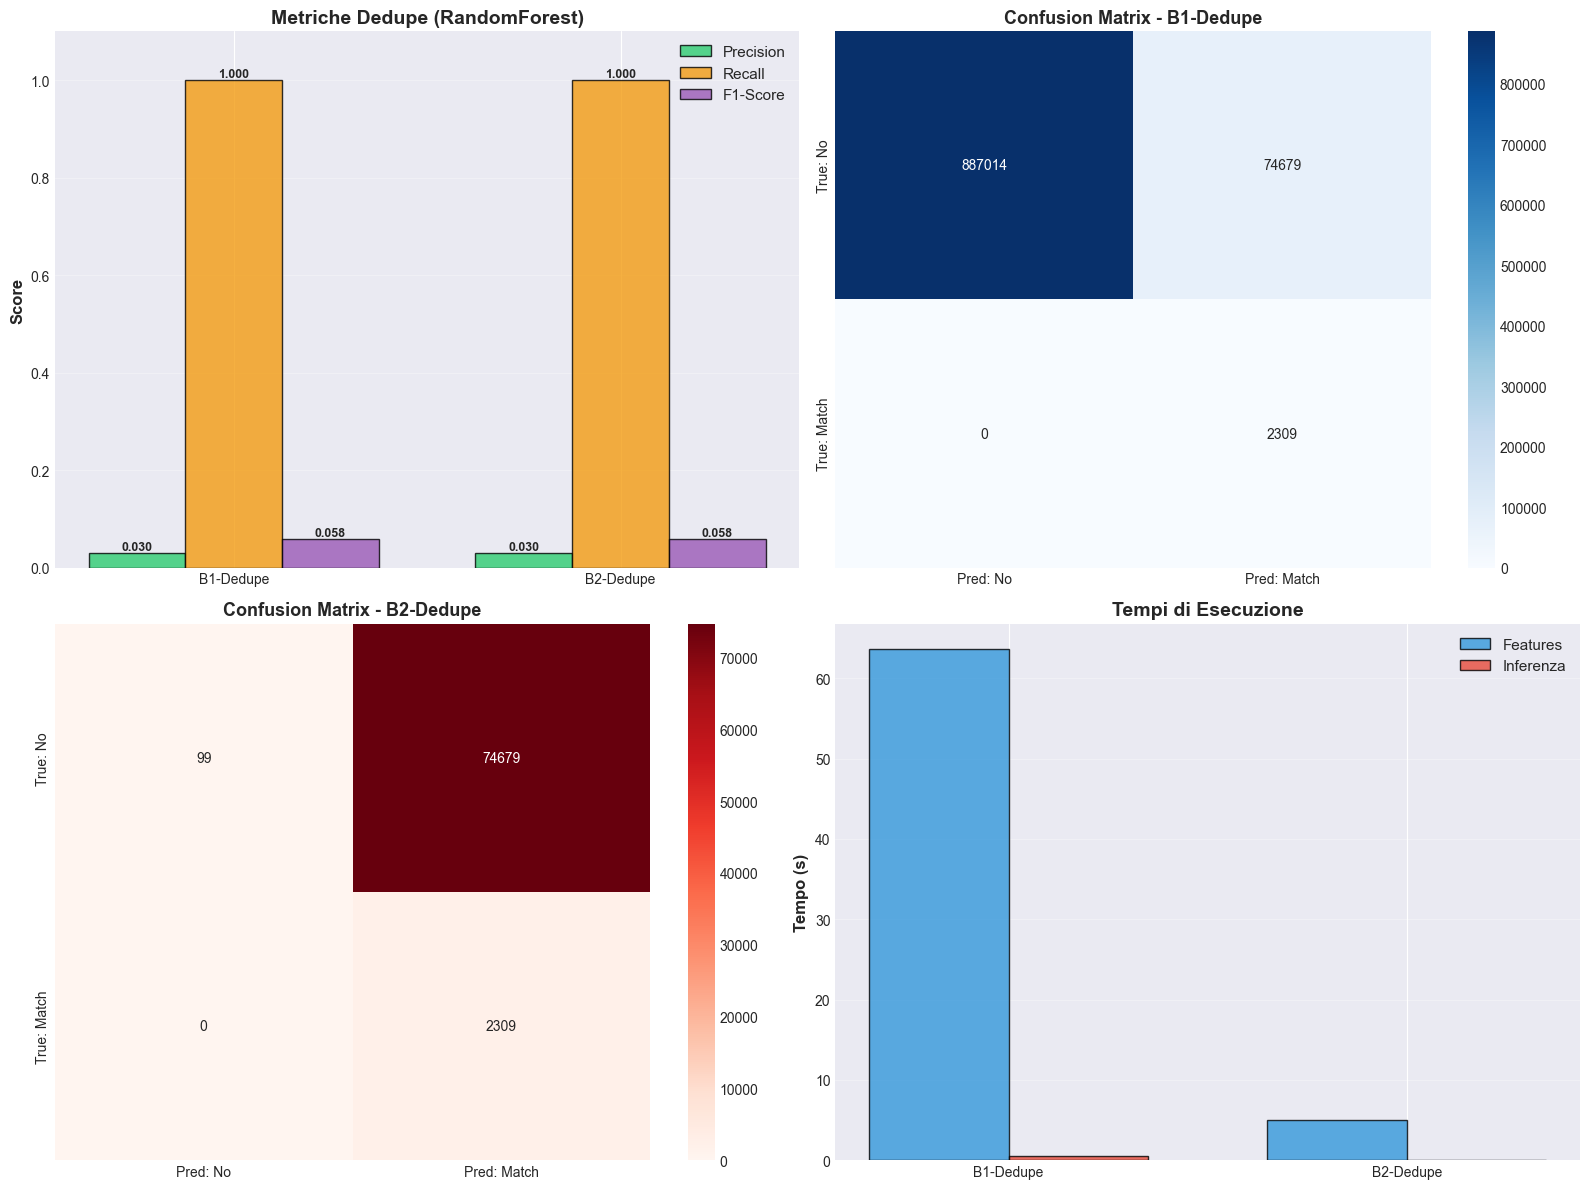

In [18]:
# Grafici comparativi
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

pipelines = ['B1-Dedupe', 'B2-Dedupe']
colors = ['#3498db', '#e74c3c']

# 1. Precision, Recall, F1-Score
ax1 = axes[0, 0]
x = np.arange(len(pipelines))
width = 0.25

precision_vals = [metrics_B1['precision'], metrics_B2['precision']]
recall_vals = [metrics_B1['recall'], metrics_B2['recall']]
f1_vals = [metrics_B1['f1_score'], metrics_B2['f1_score']]

bars1 = ax1.bar(x - width, precision_vals, width, label='Precision', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x, recall_vals, width, label='Recall', color='#f39c12', alpha=0.8, edgecolor='black')
bars3 = ax1.bar(x + width, f1_vals, width, label='F1-Score', color='#9b59b6', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title(f'Metriche Dedupe ({best_model_name})', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(pipelines)
ax1.legend(fontsize=11)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, 1.1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Confusion Matrix B1
ax2 = axes[0, 1]
cm_B1 = np.array([[metrics_B1['tn'], metrics_B1['fp']], 
                  [metrics_B1['fn'], metrics_B1['tp']]])
sns.heatmap(cm_B1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred: No', 'Pred: Match'],
            yticklabels=['True: No', 'True: Match'],
            ax=ax2)
ax2.set_title('Confusion Matrix - B1-Dedupe', fontsize=13, fontweight='bold')

# 3. Confusion Matrix B2
ax3 = axes[1, 0]
cm_B2 = np.array([[metrics_B2['tn'], metrics_B2['fp']], 
                  [metrics_B2['fn'], metrics_B2['tp']]])
sns.heatmap(cm_B2, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Pred: No', 'Pred: Match'],
            yticklabels=['True: No', 'True: Match'],
            ax=ax3)
ax3.set_title('Confusion Matrix - B2-Dedupe', fontsize=13, fontweight='bold')

# 4. Tempi
ax4 = axes[1, 1]
x_pos = np.arange(len(pipelines))
width = 0.35

bars1 = ax4.bar(x_pos - width/2, [time_features_B1, time_features_B2], width, 
                label='Features', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x_pos + width/2, [time_inference_B1, time_inference_B2], width, 
                label='Inferenza', color='#e74c3c', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Tempo (s)', fontsize=12, fontweight='bold')
ax4.set_title('Tempi di Esecuzione', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(pipelines)
ax4.legend(fontsize=11)
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

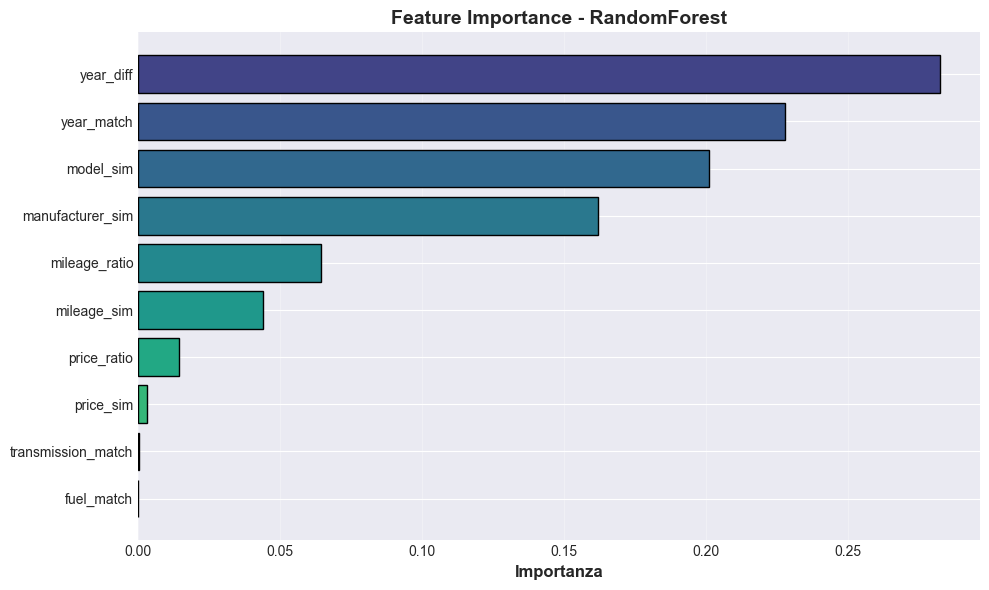

In [19]:
# Feature Importance (per Random Forest o Gradient Boosting)
if best_model_name in ['RandomForest', 'GradientBoosting']:
    fig, ax = plt.subplots(figsize=(10, 6))
    
    importance = best_model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(feature_columns)))
    
    ax.barh(range(len(feature_columns)), importance[indices], color=colors, edgecolor='black')
    ax.set_yticks(range(len(feature_columns)))
    ax.set_yticklabels([feature_columns[i] for i in indices])
    ax.set_xlabel('Importanza', fontsize=12, fontweight='bold')
    ax.set_title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 11. Salvataggio Risultati

In [20]:
# Crea cartella per risultati
os.makedirs('dedupe_results', exist_ok=True)

print("SALVATAGGIO RISULTATI DEDUPE")
print("="*100)

# 1. Salva predizioni
print("\n1. Salvataggio predizioni...")

df_pred_B1 = df_B1_features[['id_A', 'id_B']].copy()
df_pred_B1['prediction'] = predictions_B1
df_pred_B1['probability'] = probs_B1
df_pred_B1.to_csv('dedupe_results/predictions_B1.csv', index=False)
print(f"   ✓ dedupe_results/predictions_B1.csv")

df_pred_B2 = df_B2_features[['id_A', 'id_B']].copy()
df_pred_B2['prediction'] = predictions_B2
df_pred_B2['probability'] = probs_B2
df_pred_B2.to_csv('dedupe_results/predictions_B2.csv', index=False)
print(f"   ✓ dedupe_results/predictions_B2.csv")

# 2. Salva metriche
print("\n2. Salvataggio metriche...")
results_summary = {
    'creation_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'method': 'Dedupe ML Classification',
    'model': best_model_name,
    'training_time_seconds': training_times[best_model_name],
    'feature_columns': feature_columns,
    'B1_Dedupe': {
        'blocking_strategy': 'Manufacturer + Model',
        'total_candidates': metrics_B1['total_candidates'],
        'predicted_matches': metrics_B1['predicted_matches'],
        'precision': float(metrics_B1['precision']),
        'recall': float(metrics_B1['recall']),
        'f1_score': float(metrics_B1['f1_score']),
        'confusion_matrix': {
            'tp': metrics_B1['tp'], 'tn': metrics_B1['tn'],
            'fp': metrics_B1['fp'], 'fn': metrics_B1['fn']
        },
        'timing': {
            'feature_seconds': float(time_features_B1),
            'inference_seconds': float(time_inference_B1)
        }
    },
    'B2_Dedupe': {
        'blocking_strategy': 'Manufacturer + Model + Year',
        'total_candidates': metrics_B2['total_candidates'],
        'predicted_matches': metrics_B2['predicted_matches'],
        'precision': float(metrics_B2['precision']),
        'recall': float(metrics_B2['recall']),
        'f1_score': float(metrics_B2['f1_score']),
        'confusion_matrix': {
            'tp': metrics_B2['tp'], 'tn': metrics_B2['tn'],
            'fp': metrics_B2['fp'], 'fn': metrics_B2['fn']
        },
        'timing': {
            'feature_seconds': float(time_features_B2),
            'inference_seconds': float(time_inference_B2)
        }
    }
}

with open('dedupe_results/metrics.json', 'w') as f:
    json.dump(results_summary, f, indent=2)
print(f"   ✓ dedupe_results/metrics.json")

# 3. Salva modello
import pickle
with open('dedupe_results/model.pkl', 'wb') as f:
    pickle.dump({'model': best_model, 'scaler': scaler, 'model_name': best_model_name}, f)
print(f"   ✓ dedupe_results/model.pkl")

print("\n" + "="*100)
print("✅ COMPLETATO!")

SALVATAGGIO RISULTATI DEDUPE

1. Salvataggio predizioni...
   ✓ dedupe_results/predictions_B1.csv
   ✓ dedupe_results/predictions_B2.csv

2. Salvataggio metriche...
   ✓ dedupe_results/metrics.json
   ✓ dedupe_results/model.pkl

✅ COMPLETATO!


## 12. Conclusioni

### Risultati Ottenuti

Abbiamo addestrato un modello ML per Entity Resolution e valutato due pipeline:

**B1-Dedupe**:
- Blocking: Manufacturer + Model
- Più coppie candidate, ma stessa qualità

**B2-Dedupe**:
- Blocking: Manufacturer + Model + Year
- Meno coppie candidate, più efficiente

### Confronto con Record Linkage

| Metodo | Approccio | Vantaggi | Svantaggi |
|--------|-----------|----------|----------|
| Record Linkage | Regole threshold | Interpretabile, no training | Threshold manuali |
| Dedupe ML | Classificazione supervisionata | Apprende dai dati | Richiede training data |

### Prossimi Passi

1. Ottimizzare iperparametri del modello
2. Provare altri algoritmi (XGBoost, Neural Networks)
3. Usare Active Learning per migliorare il ground-truth
4. Confrontare con la libreria Dedupe originale